In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
from typing import List
import networkx as nx
import itertools
import random
import json

### Load data and build graph

In [2]:
# These two parameters can be changes by changing the priority
n_nodes = '613'
n_edges = '167263'

#grafo originale: purtroppo al momento mancano i pesi esclusa la linea di business 3: dovrei chiederla a Fra. Per questa ragione ora uso il grafo del PNRR, tanto per impostare il codice.
#filename = f'../input/actual/graph{n_nodes}_{n_edges}.json'
filename = f'../input/artificial/rescaled_graph{n_nodes}_{n_edges}.json'

with open(filename, 'r') as file:
    graph_data = json.load(file)

G = nx.Graph()

In [3]:
def calculate_weights(k, value, cs):
    v, w00, w01 = [k,value[0], value[1]]
    w1 = min(max(w00-cs[0], 0), cs[1])
    w2 = min(max(w00-cs[2], 0), cs[3])
    w3 = min(max((w01-cs[4])*0.5,0), cs[5]*0.5)
    w4 = w3
    return {v:[w1,w2,w3,w4]}

def set_weights(graph_dict):

    weights = dict()
    a=0
    b=0.027290137282490516
    c=d=0.03640364796375065
    e=f=0.08197120137005134
    cs = [a,b,c,d,e,f]

    for key in graph_dict:
        weights_values = calculate_weights(key, graph_dict[key], cs)
        weights.update(weights_values)
    return weights

In [4]:
# edges
G.add_edges_from([tuple(edge) for edge in graph_data['edges']])

# nodes
graph_weights = set_weights(graph_data['vertices'])
nx.set_node_attributes(G, {int(k):v[0] for k,v in graph_weights.items()}, 'w1')
nx.set_node_attributes(G, {int(k):v[1] for k,v in graph_weights.items()}, 'w2')
nx.set_node_attributes(G, {int(k):v[2] for k,v in graph_weights.items()}, 'w3')
nx.set_node_attributes(G, {int(k):v[3] for k,v in graph_weights.items()}, 'w4')

### Enumerate cliques

In [5]:
def find_random_k_clique(G, k, max_tries=1000):
    nodes = list(G.nodes)

    for _ in range(max_tries):
        candidate = set([random.choice(nodes)])
        while len(candidate) < k:
            neighbors = set.intersection(*(set(G.neighbors(n)) for n in candidate))
            neighbors = neighbors - candidate
            if not neighbors:
                break
            candidate.add(random.choice(list(neighbors)))
        if len(candidate) == k:
            return list(candidate)

    raise ValueError(f"Failed to find a clique of size {k} after {max_tries} attempts.")

def build_clique(node_list):
    G = nx.Graph()
    G.add_nodes_from(node_list)
    G.add_edges_from(itertools.combinations(node_list, 2))  # Fully connect all nodes
    return G

def is_exact_subgraph(G, subG):
    return (set(tmp_clique.nodes).issubset(G.nodes) and
            all(G.has_edge(u, v) for u, v in tmp_clique.edges))

def is_maximal_clique(G, clique_nodes):
    clique_set = set(clique_nodes)

    # Candidates are nodes not in the clique
    for node in set(G.nodes) - clique_set:
        if all(G.has_edge(node, c) for c in clique_set):
            # node can be added to extend the clique → not maximal
            return False
    return True

def obj_func(graph, node_labels):

    grouped_attrs = defaultdict(list)
    list_of_attrs = []
    a=100
    b=0
    c=90
    d=25
    e=0
    f=20
    g=0
    h=85
    cs = [a,b,c,d,e,f,g,h]

    for l in node_labels:
        list_of_attrs.append(graph.nodes[l])

    for d in list_of_attrs:
        for k, v in d.items():
            grouped_attrs[k].append(v)

    A_atm = sum(grouped_attrs['w1'])
    A_mp1 = sum(grouped_attrs['w2'])
    A_mp2 = sum(grouped_attrs['w3'])
    A_nat = A_mp2
    obj = min(max(A_atm -cs[0], cs[1]), cs[2]) + min(max(max(A_mp1 - cs[3], cs[4]) + A_mp2 - cs[5],cs[6]),cs[7]) + A_nat

    return obj

In [29]:
max_k=28
max_n=1000

cliques = defaultdict(List[list])
is_maximal = defaultdict(list)

for k in range(2, max_k+1):
    print(f'collecting cliques of size k: {k}')
    cliques_of_size_k = []
    is_maximal_k = []
    for n in range(1,max_n+1):
        try:
            tmp_nodes = find_random_k_clique(G, k)
            tmp_clique = build_clique(tmp_nodes)
            cliques_of_size_k.append(tmp_clique)
            is_maximal_k.append(is_maximal_clique(G, tmp_clique))
        except:
            continue
    cliques[k] = cliques_of_size_k
    is_maximal[k] = is_maximal_k

#example_k = 3
#example_clique = cliques[example_k][0]
#print(is_exact_subgraph(G, example_clique))
#print(is_maximal_clique(G, cliques[example_k][0].nodes()))
#print(obj_func(G, list(example_clique.nodes())))
#nx.draw(example_clique, with_labels=True)
#plt.show()

collecting cliques of size k: 2
collecting cliques of size k: 3
collecting cliques of size k: 4
collecting cliques of size k: 5
collecting cliques of size k: 6
collecting cliques of size k: 7
collecting cliques of size k: 8
collecting cliques of size k: 9
collecting cliques of size k: 10
collecting cliques of size k: 11
collecting cliques of size k: 12
collecting cliques of size k: 13
collecting cliques of size k: 14
collecting cliques of size k: 15
collecting cliques of size k: 16
collecting cliques of size k: 17
collecting cliques of size k: 18
collecting cliques of size k: 19
collecting cliques of size k: 20
collecting cliques of size k: 21
collecting cliques of size k: 22
collecting cliques of size k: 23
collecting cliques of size k: 24
collecting cliques of size k: 25
collecting cliques of size k: 26
collecting cliques of size k: 27
collecting cliques of size k: 28


In [30]:
n_maximals = {k: sum(v) for k, v in is_maximal.items()}
n_cliques = {k: len(v) for k, v in is_maximal.items()}

result = {k: n_maximals[k] / n_cliques[k] for k in is_maximal}

<BarContainer object of 27 artists>

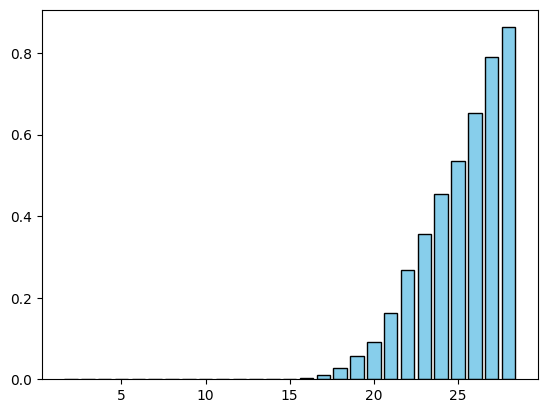

In [32]:
plt.bar(result.keys(), result.values(), color='skyblue', edgecolor='black')